In [16]:
import pandas as pd
import numpy as np

In [17]:
# Load data
train = pd.read_table('ml-100k/u2.base', header=None, names=['uid', 'mid', 'rating', 'timestamp'])
test  = pd.read_table('ml-100k/u2.test', header=None, names=['uid', 'mid', 'rating', 'timestamp'])

n_users  = int(training.describe().loc['max', 'uid'])
n_movies = int(training.describe().loc['max', 'mid'])

In [18]:
# Transform
Y = np.zeros( (n_movies, n_users) )
R = Y.copy()
for i in range(train.shape[0]):
    Y[train.mid[i]-1][train.uid[i]-1] = train.rating[i]
    R[train.mid[i]-1][train.uid[i]-1] = 1

# Item-based Collaborative Filtering

In [19]:
# Allocate
weights    = np.empty((n_movies,n_movies))
diff       = np.empty((n_movies, n_users))
std_rating = np.empty(n_movies)

Y_mu = Y.sum(axis=1)/R.sum(axis=1)
for i in range(n_movies):
    diff[i,:] = Y[i,:]-Y_mu[i]
    std_rating[i] = np.power(diff[i,:],2).sum()/R[i,:].sum()

In [20]:
# Weighting (Pearson correlation)
for i in range(n_movies):
    for j in range(n_movies):
        weights[i,j] = np.dot(R[i,:]*diff[i,:], R[j,:]*diff[j,:])/(std_rating[i]*std_rating[j])

In [21]:
# Predict
pred_correlation = np.empty(test.shape[0])
pred_flag        = pred_correlation.copy()
pred_cosine      = pred_correlation.copy()
thredhold = 0
tolerence = 1
for test_id in range(test.shape[0]):
    a = test.uid[test_id]
    i = test.mid[test_id]

    idx_positive_weights    = np.array([j for j in range(weights.shape[0]) if weights[i,j]>thredhold])
    val_positive_weights    = weights[np.ix_([i],idx_positive_weights)][0]
    val_positive_difference = (diff[np.ix_(idx_positive_weights,[a])].T)[0] * (R[np.ix_(idx_positive_weights,[a])].T)[0]
    pred_correlation[test_id] = Y_mu[i] + np.dot(val_positive_difference,val_positive_weights)/(val_positive_weights.sum())

    pred_flag[test_id] = 1
pred_has_pred = [i for i in range(test.shape[0]) if pred_flag[i]]

In [22]:
# Validation
error   = test.rating.iloc[pred_has_pred] - pred_correlation[np.ix_(pred_has_pred)]
correct = np.array([error[i] for i in range(test.shape[0]) if np.abs(error[i])<tolerence])
correct_proportion = correct.shape[0]/float(test.shape[0])

Populating the interactive namespace from numpy and matplotlib
0.56645


`%matplotlib` prevents importing * from pylab and numpy


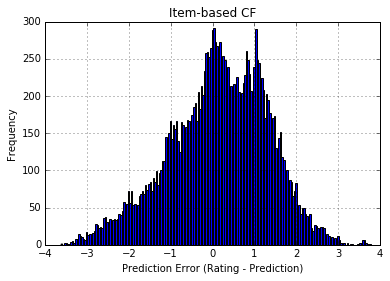

In [23]:
# Visualization
%pylab inline
error.hist(bins=200)
plt.xlabel("Prediction Error (Rating - Prediction)")
plt.ylabel("Frequency")
plt.title("Item-based CF")
print correct_proportion

# User-based Collaborative Filtering

0.58415


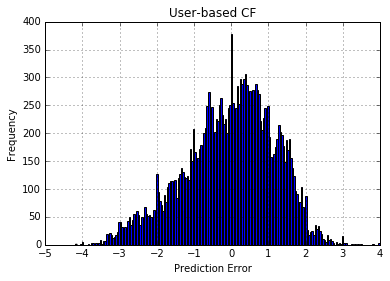

In [25]:
test  = pd.read_table('ml-100k/u2.test', header=None, names=['uid', 'mid', 'rating', 'timestamp'])

Y_mu = Y.sum(axis=0)/R.sum(axis=0)

# Allocate
weights    = np.empty((n_users,n_users))
diff       = np.empty((n_movies, n_users))
std_rating = np.empty(n_users)

for i in range(n_users):
    diff[:,i] = Y[:,i]-Y_mu[i]
    std_rating[i] = np.power(diff[:,i],2).sum()/R[:,i].sum()

# Weighting (Pearson correlation)
for i in range(n_users):
    for j in range(n_users):
        weights[i,j] = np.dot(R[:,i]*diff[:,i], R[:,j]*diff[:,j])/(std_rating[i]*std_rating[j])

# Predict
pred_correlation = np.zeros(test.shape[0])
pred_flag        = pred_correlation.copy()
pred_cosine      = pred_correlation.copy()
thredhold = 0
tolerence = 1

movie_avg_rating = Y.sum(axis=1)/R.sum(axis=1)
for test_id in range(test.shape[0]):
    a = test.uid[test_id]
    i = test.mid[test_id]

    if i < Y.shape[1]:
        idx_positive_weights    = np.array([j for j in range(weights.shape[0]) if weights[j,a]>thredhold])
        val_positive_weights    = (weights[np.ix_(idx_positive_weights,[a])].T)[0]
        val_positive_difference = (diff[np.ix_([i],idx_positive_weights)])[0] * (R[np.ix_([i],idx_positive_weights)])[0]
        pred_correlation[test_id] = Y_mu[i] + np.dot(val_positive_difference,val_positive_weights)/(val_positive_weights.sum())
    else:
        pred_correlation[test_id] = movie_avg_rating[i]
# Validation
error   = test.rating - pred_correlation
correct = np.array([error[i] for i in range(error.shape[0]) if np.abs(error[i])<tolerence])
correct_proportion = correct.shape[0]/float(test.shape[0])

error.hist(bins=200)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("User-based CF")
print correct_proportion
